# CS231a PSET 2

You can use this colab notebook to write your code in, which could save you the trouble of having to set up Python or installing packages.

# Problem 1: Fundamental Matrix Estimation From Point Correspondences

Make sure you have run the code block above and have access to the data for this problem. Now, you can fill out the logic for this problem. Once done, copy it to p1.py for submission to Gradescope.

--------------------------------------------------------------------------------
Set: data/set1
--------------------------------------------------------------------------------
Fundamental Matrix from LLS  8-point algorithm:
 [[ 0.000002 -0.000008 -0.001504]
 [-0.000006 -0.       -0.011361]
 [-0.003523  0.014145  0.999828]]
Distance to lines in image 1 for LLS: 28.025662937501366
Distance to lines in image 2 for LLS: 25.162875800010667
p'^T F p = 0.0522934179547665
Fundamental Matrix from normalized 8-point algorithm:
 [[ 0.000001 -0.000008  0.000149]
 [-0.000007 -0.000001 -0.009842]
 [-0.001258  0.013521  0.204133]]
Distance to lines in image 1 for normalized: 0.9400730444594929
Distance to lines in image 2 for normalized: 0.8666869827347681


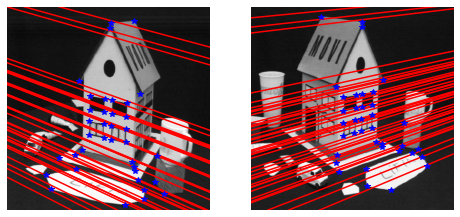

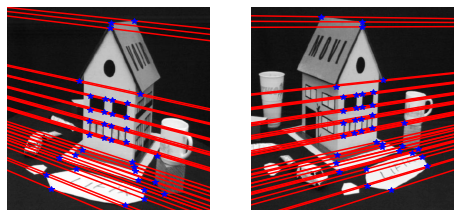

--------------------------------------------------------------------------------
Set: data/set2
--------------------------------------------------------------------------------
Fundamental Matrix from LLS  8-point algorithm:
 [[-0.000006  0.000027 -0.006427]
 [-0.000028 -0.000007  0.015218]
 [ 0.010762 -0.012252 -0.999731]]
Distance to lines in image 1 for LLS: 9.701438829445726
Distance to lines in image 2 for LLS: 14.568227190514545
p'^T F p = 0.048141543939037135
Fundamental Matrix from normalized 8-point algorithm:
 [[-0.        0.000004 -0.000234]
 [ 0.000005  0.        0.010544]
 [ 0.000367 -0.012799 -0.006796]]
Distance to lines in image 1 for normalized: 0.8987125121520279
Distance to lines in image 2 for normalized: 0.8981584726201726


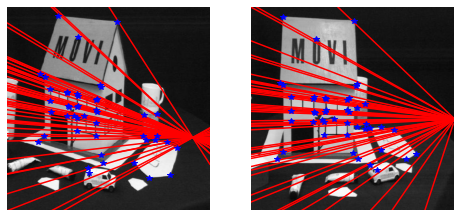

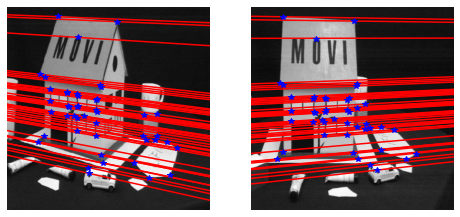

In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from epipolar_utils import *
np.set_printoptions(precision=6, suppress=True)

'''
LLS_EIGHT_POINT_ALG  computes the fundamental matrix from matching points using
linear least squares eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the linear least squares eight
point algorithm works
'''
def lls_eight_point_alg(points1, points2):
    N = points1.shape[0]
    W = np.ones((N, 9))
    # make W matrix (N x 9)
    # we are finding F such that (points2)^T * F * points1 = 0
    # so W matrix's each row is (uu', u'v, u', uv', vv', v', u, v, 1)
    for i in range(N):
        u = points1[i, 0]; u_prime = points2[i, 0]
        v = points1[i, 1]; v_prime = points2[i, 1]
        W[i, 0] = u * u_prime
        W[i, 1] = u_prime * v
        W[i, 2] = u_prime
        W[i, 3] = u * v_prime
        W[i, 4] = v * v_prime
        W[i, 5] = v_prime
        W[i, 6] = u
        W[i, 7] = v

    _, _, Vt = np.linalg.svd(W)
    V = Vt.T
    # Last column of V would be F_hat (F11, F12, F13, F21, F22, F23, F31, F32, F33)
    F_hat = V[:, -1].reshape((3, 3))
    # Normalize for |F|=1 because V is orthogonal matrix (not orthonormal)
    F_hat = F_hat / np.linalg.norm(F_hat)

    # We found F_hat which may have full rank
    # But true fundamental matrix has rank 2
    # So we should look for a solution that is the best rank-2 approximation of F_hat.
    U, S, Vt = np.linalg.svd(F_hat)
    S_rank_2 = np.zeros((3, 3))
    S_rank_2[0, 0] = S[0]
    S_rank_2[1, 1] = S[1]
    F = np.dot(np.dot(U, S_rank_2), Vt)
    return F

'''
NORMALIZED_EIGHT_POINT_ALG  computes the fundamental matrix from matching points
using the normalized eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the normalized eight
point algorithm works
'''
def normalized_eight_point_alg(points1, points2):
    # calculate each centroids
    p_centroid = np.mean(points1, axis=0)
    p_prime_centroid = np.mean(points2, axis=0)
    # translate (the origin of the new coordinate system should be centroid)
    t_p = (points1 - p_centroid)[:, 0:-1]
    t_p_prime = (points2 - p_prime_centroid)[:, 0:-1]

    # scaling factor (2 / mean_distance)
    s = 2 / np.mean(np.sqrt(np.sum(t_p ** 2, axis=1)))
    s_prime = 2 / np.mean(np.sqrt(np.sum(t_p_prime ** 2, axis=1)))
    # So now we know scaling and translation matrix
    # Thus we can build transformation matrix T and T_prime
    # Translation first and then scaling occured
    # Watch out for the sequence of translation and scaling
    T = np.array([[s, 0, -(s * p_centroid[0])],
                  [0, s, -(s * p_centroid[1])],
                  [0, 0, 1]])
    T_prime = np.array([[s_prime, 0, -(s * p_centroid[0])],
                        [0, s_prime, -(s * p_centroid[1])],
                        [0, 0, 1]])
    q = np.dot(T, points1.T).T
    q_prime = np.dot(T_prime, points2.T).T

    # Find fundamental matrix with normalized points
    F_q = lls_eight_point_alg(q, q_prime)

    # De-normalize is (F = T^T * F_q * T_prime) if (points1)^T * F * points2 = 0
    # but now F is fundamental matrix such that (points2)^T * F * points1 = 0
    # So de-normalize equation should be F = T'^T * F_q * T
    F = np.dot(np.dot(T_prime.T, F_q), T)
    return F

'''
PLOT_EPIPOLAR_LINES_ON_IMAGES given a pair of images and corresponding points,
draws the epipolar lines on the images
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    im1 - a HxW(xC) matrix that contains pixel values from the first image
    im2 - a HxW(xC) matrix that contains pixel values from the second image
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    Nothing; instead, plots the two images with the matching points and
    their corresponding epipolar lines. See Figure 1 within the problem set
    handout for an example
'''
def plot_epipolar_lines_on_images(points1, points2, im1, im2, F):

    def plot_epipolar_lines_on_image(points1, points2, im, F):
        im_height = im.shape[0]
        im_width = im.shape[1]
        lines = F.T.dot(points2.T) # These should be also Fp' not F^Tp'
        plt.imshow(im, cmap='gray')
        for line in lines.T:
            a,b,c = line
            xs = [1, im.shape[1]-1]
            ys = [(-c-a*x)/b for x in xs]
            plt.plot(xs, ys, 'r')
        for i in range(points1.shape[0]):
            x,y,_ = points1[i]
            plt.plot(x, y, '*b')
        plt.axis([0, im_width, im_height, 0])

    # We change the figsize because matplotlib has weird behavior when
    # plotting images of different sizes next to each other. This
    # fix should be changed to something more robust.
    new_figsize = (8 * (float(max(im1.shape[1], im2.shape[1])) / min(im1.shape[1], im2.shape[1]))**2 , 6)
    fig = plt.figure(figsize=new_figsize)
    plt.subplot(121)
    plot_epipolar_lines_on_image(points1, points2, im1, F)
    plt.axis('off')
    plt.subplot(122)
    plot_epipolar_lines_on_image(points2, points1, im2, F.T)
    plt.axis('off')

'''
COMPUTE_DISTANCE_TO_EPIPOLAR_LINES  computes the average distance of a set a
points to their corresponding epipolar lines. Compute just the average distance
from points1 to their corresponding epipolar lines (which you get from points2).
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    average_distance - the average distance of each point to the epipolar line
'''
def compute_distance_to_epipolar_lines(points1, points2, F):
    # F - the fundamental matrix such that (points2)^T * F * points1 = 0
    # l = Fp' and l' = F^Tp
    # so in this problem, l = F*points1 and l'=F^T*points2
    l = np.dot(F.T, points2.T)

    # Distance between point and line is |ax0+by0+c| / sqrt(a^2+b^2)
    a = l[0, :]; b = l[1, :]; c = l[2, :]
    x = points1[:, 0]; y = points1[:, 1]
    dist = np.abs(a * x + b * y + c) / np.sqrt(a ** 2 + b ** 2)
    avg_dist = np.mean(dist)
    return avg_dist


if __name__ == '__main__':
    for im_set in ['data/set1', 'data/set2']:
        print('-'*80)
        print("Set:", im_set)
        print('-'*80)

        # Read in the data
        im1 = imread(im_set+'/image1.jpg')
        im2 = imread(im_set+'/image2.jpg')
        points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
        points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
        assert (points1.shape == points2.shape)

        # Running the linear least squares eight point algorithm
        F_lls = lls_eight_point_alg(points1, points2)
        print("Fundamental Matrix from LLS  8-point algorithm:\n", F_lls)
        print("Distance to lines in image 1 for LLS:", \
            compute_distance_to_epipolar_lines(points1, points2, F_lls))
        print("Distance to lines in image 2 for LLS:", \
            compute_distance_to_epipolar_lines(points2, points1, F_lls.T))

        # Running the normalized eight point algorithm
        F_normalized = normalized_eight_point_alg(points1, points2)

        pFp = [points2[i].dot(F_normalized.dot(points1[i]))
            for i in range(points1.shape[0])]
        print("p'^T F p =", np.abs(pFp).max())
        print("Fundamental Matrix from normalized 8-point algorithm:\n", \
            F_normalized)
        print("Distance to lines in image 1 for normalized:", \
            compute_distance_to_epipolar_lines(points1, points2, F_normalized))
        print("Distance to lines in image 2 for normalized:", \
            compute_distance_to_epipolar_lines(points2, points1, F_normalized.T))

        # Plotting the epipolar lines
        plot_epipolar_lines_on_images(points1, points2, im1, im2, F_lls)
        plot_epipolar_lines_on_images(points1, points2, im1, im2, F_normalized)

        plt.show()



# Problem 2: Matching Homographies for Image Rectification

First, make sure you have access to the data. Then, complete this code and then copy it to p2.py for submission to Gradescope.

e1 [-1307.251364  -136.748738     1.      ]
e2 [1651.38691    45.767809    1.      ]



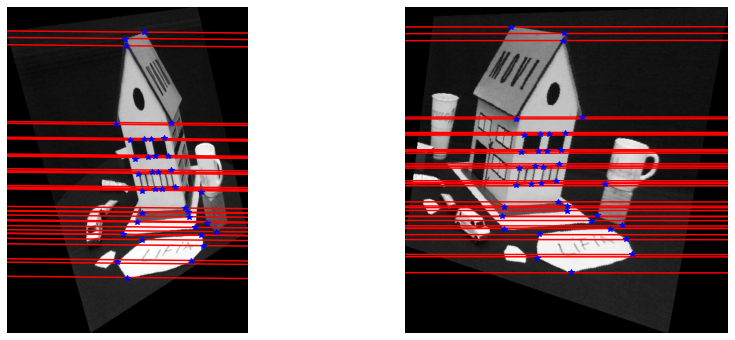

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from p1 import *
from epipolar_utils import *
np.set_printoptions(precision=6, suppress=True)

'''
COMPUTE_EPIPOLE computes the epipole e in homogenous coordinates
given the fundamental matrix
Arguments:
    F - the Fundamental matrix solved for with normalized_eight_point_alg(points1, points2)

Returns:
    epipole - the homogenous coordinates [x y 1] of the epipole in the image
'''
def compute_epipole(F):
    # Return of F is e2 and return of F^T is e1
    # Fe' = 0 and e' = e1 so F have to be transposed.
    F = F.T
    _, _, Vt = np.linalg.svd(F, full_matrices=True)
    V = Vt.T
    e = V[:, -1]
    # e should be homogeneous coordinate
    # so we should normalize it
    e = e / e[-1]
    return e

'''
COMPUTE_H computes a homography to map an epipole to infinity along the horizontal axis
Arguments:
    e - the epipole
    im2 - the image
Returns:
    H - homography matrix
'''
def compute_H(e, im):
    h, w = im.shape

    # Translation matrix
    T = np.eye(3)
    T[0, 2] = -(w / 2.)
    T[1, 2] = -(h / 2.)
    # Rotation matrix
    R = np.zeros((3, 3))
    R[2, 2] = 1.
    t_e = np.dot(T, e)
    if t_e[0] >= 0:
        alpha = 1
    else:
        alpha = -1
    R[0, 0] = alpha * t_e[0] / (t_e[0] ** 2 + t_e[1] ** 2) ** 0.5
    R[0, 1] = alpha * t_e[1] / (t_e[0] ** 2 + t_e[1] ** 2) ** 0.5
    R[1, 0] = - alpha * t_e[1] / (t_e[0] ** 2 + t_e[1] ** 2) ** 0.5
    R[1, 1] = alpha * t_e[0] / (t_e[0] ** 2 + t_e[1] ** 2) ** 0.5
    # Transformation G matrix
    G = np.eye(3)
    rt_e = np.dot(R, t_e)
    G[2, 0] = - (1. / rt_e[0])
    # H_2
    H_2 = np.dot(np.dot(np.dot(np.linalg.inv(T), G), R), T)
    return H_2

'''
COMPUTE_MATCHING_HOMOGRAPHIES determines homographies H1 and H2 such that they
rectify a pair of images
Arguments:
    e2 - the second epipole
    F - the Fundamental matrix
    im2 - the second image
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
Returns:
    H1 - the homography associated with the first image
    H2 - the homography associated with the second image
'''
def compute_matching_homographies(e2, F, im2, points1, points2):
    H_2 = compute_H(e2, im2)
    # So we have to find H_1 for image1.
    # now H_1 = H_A H_2 H_M

    # Cross product matrix [e]x
    ex = np.array([[0, -e2[2], e2[1]],
                   [e2[2], 0, -e2[0]],
                   [-e2[1], e2[0], 0]])

    # Then we need M
    v = np.array([1., 1., 1.])
    M = np.dot(ex, F) + np.outer(e2, v)

    p_hat = np.dot(np.dot(H_2, M), points1.T).T
    p_hat_prime = np.dot(H_2, points2.T).T

    # Normalize p_hat and p_prime_hat because it is homogeneous coordinates.
    p_hat = p_hat / p_hat[:, -1].reshape(-1, 1)
    p_hat_prime = p_hat_prime / p_hat_prime[:, -1].reshape(-1, 1)

    # Wa = b
    b = p_hat_prime[:, 0]
    W = np.ones(p_hat.shape)
    W[:, 0:2] = p_hat[:, 0:2]
    a = np.linalg.lstsq(W, b, rcond=None)[0]
    H_A = np.eye(3)
    H_A[0, :] = a.T

    H_1 = np.dot(np.dot(H_A, H_2), M)
    return H_1, H_2

if __name__ == '__main__':
    # Read in the data
    im_set = 'data/set1'
    im1 = imread(im_set+'/image1.jpg')
    im2 = imread(im_set+'/image2.jpg')
    points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
    assert (points1.shape == points2.shape)

    F = normalized_eight_point_alg(points1, points2)
    # F is such that (points2)^T * F * points1 = 0, so e1 is e' and e2 is e
    e1 = compute_epipole(F.T)
    e2 = compute_epipole(F)
    print("e1", e1)
    print("e2", e2)

    # Find the homographies needed to rectify the pair of images
    H1, H2 = compute_matching_homographies(e2, F, im2, points1, points2)
    print('')

    # Transforming the images by the homographies
    new_points1 = H1.dot(points1.T)
    new_points2 = H2.dot(points2.T)
    new_points1 /= new_points1[2,:]
    new_points2 /= new_points2[2,:]
    new_points1 = new_points1.T
    new_points2 = new_points2.T
    rectified_im1, offset1 = compute_rectified_image(im1, H1)
    rectified_im2, offset2 = compute_rectified_image(im2, H2)
    new_points1 -= offset1 + (0,)
    new_points2 -= offset2 + (0,)

    # Plotting the image
    F_new = normalized_eight_point_alg(new_points1, new_points2)
    plot_epipolar_lines_on_images(new_points1, new_points2, rectified_im1, rectified_im2, F_new)
    plt.show()


# Problem 3: The Factorization Method

First, make sure you have access to the data. Then, complete this code and then copy it to p3.py for submission to Gradescope.

In [ ]:
# PSET 2 Problem 3
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib.gridspec as gridspec
from epipolar_utils import *

'''
FACTORIZATION_METHOD The Tomasi and Kanade Factorization Method to determine
the 3D structure of the scene and the motion of the cameras.
Arguments:
    points_im1 - N points in the first image that match with points_im2
    points_im2 - N points in the second image that match with points_im1

    Both points_im1 and points_im2 are from the get_data_from_txt_file() method
Returns:
    structure - the structure matrix
    motion - the motion matrix
'''
def factorization_method(points_im1, points_im2):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')

if __name__ == '__main__':
    for im_set in ['data/set1', 'data/set1_subset']:
        # Read in the data
        im1 = imread(im_set+'/image1.jpg')
        im2 = imread(im_set+'/image2.jpg')
        points_im1 = get_data_from_txt_file(im_set + '/pt_2D_1.txt')
        points_im2 = get_data_from_txt_file(im_set + '/pt_2D_2.txt')
        points_3d = get_data_from_txt_file(im_set + '/pt_3D.txt')
        assert (points_im1.shape == points_im2.shape)

        # Run the Factorization Method
        structure, motion = factorization_method(points_im1, points_im2)

        # Plot the structure
        fig = plt.figure()
        ax = fig.add_subplot(121, projection = '3d')
        scatter_3D_axis_equal(structure[0,:], structure[1,:], structure[2,:], ax)
        ax.set_title('Factorization Method')
        ax = fig.add_subplot(122, projection = '3d')
        scatter_3D_axis_equal(points_3d[:,0], points_3d[:,1], points_3d[:,2], ax)
        ax.set_title('Ground Truth')

        plt.show()

# Problem 4: Triangulation in Structure From Motion

First, make sure you have access to the data. Then, complete this code and then copy it to p4.py for submission to Gradescope.

In [ ]:
# PSET 2 Problem 4
import sys
import numpy as np
import os
from scipy.optimize import least_squares
import math
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.io import imread
from sfm_utils import *

'''
ESTIMATE_INITIAL_RT from the Essential Matrix, we can compute 4 initial
guesses of the relative RT between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
Returns:
    RT: A 4x3x4 tensor in which the 3x4 matrix RT[i,:,:] is one of the
        four possible transformations
'''
def estimate_initial_RT(E):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')

'''
LINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point is the best linear estimate
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''
def linear_estimate_3d_point(image_points, camera_matrices):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')

'''
REPROJECTION_ERROR given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    error - the 2Mx1 reprojection error vector
'''
def reprojection_error(point_3d, image_points, camera_matrices):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')

'''
JACOBIAN given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    jacobian - the 2Mx3 Jacobian matrix
'''
def jacobian(point_3d, camera_matrices):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')

'''
NONLINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point that iteratively updates the points
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''
def nonlinear_estimate_3d_point(image_points, camera_matrices):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')

'''
ESTIMATE_RT_FROM_E from the Essential Matrix, we can compute  the relative RT 
between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
    image_points - N measured points in each of the M images (NxMx2 matrix)
    K - the intrinsic camera matrix
Returns:
    RT: The 3x4 matrix which gives the rotation and translation between the 
        two cameras
'''
def estimate_RT_from_E(E, image_points, K):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')

if __name__ == '__main__':
    run_pipeline = True

    # Load the data
    image_data_dir = 'data/statue/'
    unit_test_camera_matrix = np.load('data/unit_test_camera_matrix.npy')
    unit_test_image_matches = np.load('data/unit_test_image_matches.npy')
    image_paths = [os.path.join(image_data_dir, 'images', x) for x in
        sorted(os.listdir('data/statue/images')) if '.jpg' in x]
    focal_length = 719.5459
    matches_subset = np.load(os.path.join(image_data_dir,
        'matches_subset.npy'), allow_pickle=True, encoding='latin1')[0,:]
    dense_matches = np.load(os.path.join(image_data_dir, 'dense_matches.npy'), 
                               allow_pickle=True, encoding='latin1')
    fundamental_matrices = np.load(os.path.join(image_data_dir,
        'fundamental_matrices.npy'), allow_pickle=True, encoding='latin1')[0,:]

    # Part A: Computing the 4 initial R,T transformations from Essential Matrix
    print('-' * 80)
    print("Part A: Check your matrices against the example R,T")
    print('-' * 80)
    K = np.eye(3)
    K[0,0] = K[1,1] = focal_length
    E = K.T.dot(fundamental_matrices[0]).dot(K)
    im0 = imread(image_paths[0])
    im_height, im_width, _ = im0.shape
    example_RT = np.array([[0.9736, -0.0988, -0.2056, 0.9994],
        [0.1019, 0.9948, 0.0045, -0.0089],
        [0.2041, -0.0254, 0.9786, 0.0331]])
    print("Example RT:\n", example_RT)
    estimated_RT = estimate_initial_RT(E)
    print('')
    print("Estimated RT:\n", estimated_RT)

    # Part B: Determining the best linear estimate of a 3D point
    print('-' * 80)
    print('Part B: Check that the difference from expected point ')
    print('is near zero')
    print('-' * 80)
    camera_matrices = np.zeros((2, 3, 4))
    camera_matrices[0, :, :] = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
    camera_matrices[1, :, :] = K.dot(example_RT)
    unit_test_matches = matches_subset[0][:,0].reshape(2,2)
    estimated_3d_point = linear_estimate_3d_point(unit_test_matches.copy(),
        camera_matrices.copy())
    expected_3d_point = np.array([0.6774, -1.1029, 4.6621])
    print("Difference: ", np.fabs(estimated_3d_point - expected_3d_point).sum())

    # Part C: Calculating the reprojection error and its Jacobian
    print('-' * 80)
    print('Part C: Check that the difference from expected error/Jacobian ')
    print('is near zero')
    print('-' * 80)
    estimated_error = reprojection_error(
            expected_3d_point, unit_test_matches, camera_matrices)
    estimated_jacobian = jacobian(expected_3d_point, camera_matrices)
    expected_error = np.array((-0.0095458, -0.5171407,  0.0059307,  0.501631))
    print("Error Difference: ", np.fabs(estimated_error - expected_error).sum())
    expected_jacobian = np.array([[ 154.33943931, 0., -22.42541691],
         [0., 154.33943931, 36.51165089],
         [141.87950588, -14.27738422, -56.20341644],
         [21.9792766, 149.50628901, 32.23425643]])
    print("Jacobian Difference: ", np.fabs(estimated_jacobian
        - expected_jacobian).sum())

    # Part D: Determining the best nonlinear estimate of a 3D point
    print('-' * 80)
    print('Part D: Check that the reprojection error from nonlinear method')
    print('is lower than linear method')
    print('-' * 80)
    estimated_3d_point_linear = linear_estimate_3d_point(
        unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
    estimated_3d_point_nonlinear = nonlinear_estimate_3d_point(
        unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
    error_linear = reprojection_error(
        estimated_3d_point_linear, unit_test_image_matches,
        unit_test_camera_matrix)
    print("Linear method error:", np.linalg.norm(error_linear))
    error_nonlinear = reprojection_error(
        estimated_3d_point_nonlinear, unit_test_image_matches,
        unit_test_camera_matrix)
    print("Nonlinear method error:", np.linalg.norm(error_nonlinear))

    # Part E: Determining the correct R, T from Essential Matrix
    print('-' * 80)
    print("Part E: Check your matrix against the example R,T")
    print('-' * 80)
    estimated_RT = estimate_RT_from_E(E,
        np.expand_dims(unit_test_image_matches[:2,:], axis=0), K)
    print("Example RT:\n", example_RT)
    print('')
    print("Estimated RT:\n", estimated_RT)

    # Part F: Run the entire Structure from Motion pipeline
    if not run_pipeline:
        sys.exit()
    print('-' * 80)
    print('Part F: Run the entire SFM pipeline')
    print('-' * 80)
    frames = [0] * (len(image_paths) - 1)
    for i in range(len(image_paths)-1):
        frames[i] = Frame(matches_subset[i].T, focal_length,
                fundamental_matrices[i], im_width, im_height)
        bundle_adjustment(frames[i])
    merged_frame = merge_all_frames(frames)

    # Construct the dense matching
    camera_matrices = np.zeros((2,3,4))
    dense_structure = np.zeros((0,3))
    for i in range(len(frames)-1):
        matches = dense_matches[i]
        camera_matrices[0,:,:] = merged_frame.K.dot(
            merged_frame.motion[i,:,:])
        camera_matrices[1,:,:] = merged_frame.K.dot(
                merged_frame.motion[i+1,:,:])
        points_3d = np.zeros((matches.shape[1], 3))
        use_point = np.array([True]*matches.shape[1])
        for j in range(matches.shape[1]):
            points_3d[j,:] = nonlinear_estimate_3d_point(
                matches[:,j].reshape((2,2)), camera_matrices)
        dense_structure = np.vstack((dense_structure, points_3d[use_point,:]))

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.scatter(dense_structure[:,0], dense_structure[:,1], dense_structure[:,2],
        c='k', depthshade=True, s=2)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(0, 10)
    ax.view_init(-100, 90)

    plt.show()

That's it, you are done! Remember to submit your code by copying the code from Colab to p[X].py, and submitting it to Gradescope by zipping the .py files and uploading the zip file to the coding assignment.

